In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

sns.set(style='whitegrid')

np.random.seed(42)

import torch
import torch.nn as nn

In [111]:
torch.manual_seed(87) 
player_cleaned_df = pd.read_csv('../data/cleaned/player_attributes_cleaned.csv')
player_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177037 entries, 0 to 177036
Data columns (total 43 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   player_api_id        177037 non-null  int64  
 1   height               177037 non-null  float64
 2   weight               177037 non-null  float64
 3   date                 177037 non-null  object 
 4   age                  177037 non-null  float64
 5   overall_rating       177037 non-null  float64
 6   potential            177037 non-null  float64
 7   preferred_foot       177037 non-null  float64
 8   attacking_work_rate  177037 non-null  float64
 9   defensive_work_rate  177037 non-null  float64
 10  crossing             177037 non-null  float64
 11  finishing            177037 non-null  float64
 12  heading_accuracy     177037 non-null  float64
 13  short_passing        177037 non-null  float64
 14  volleys              177037 non-null  float64
 15  dribbling        

In [112]:
player_cleaned_df = player_cleaned_df.drop(columns=['date'])
player_cleaned_df.head(20)
player_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177037 entries, 0 to 177036
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   player_api_id        177037 non-null  int64  
 1   height               177037 non-null  float64
 2   weight               177037 non-null  float64
 3   age                  177037 non-null  float64
 4   overall_rating       177037 non-null  float64
 5   potential            177037 non-null  float64
 6   preferred_foot       177037 non-null  float64
 7   attacking_work_rate  177037 non-null  float64
 8   defensive_work_rate  177037 non-null  float64
 9   crossing             177037 non-null  float64
 10  finishing            177037 non-null  float64
 11  heading_accuracy     177037 non-null  float64
 12  short_passing        177037 non-null  float64
 13  volleys              177037 non-null  float64
 14  dribbling            177037 non-null  float64
 15  curve            

In [113]:
import numpy as np
import torch

# Define which columns to use as input features
feature_cols = [col for col in player_cleaned_df.columns if col not in ['overall_rating', 'player_api_id']]
sequence_length = 3

X_list = []
y_list = []

# Group data by player
for _, group in player_cleaned_df.groupby('player_api_id'):
    group = group.reset_index(drop=True)
    if len(group) <= sequence_length:
        continue

    for i in range(len(group) - sequence_length):
        X_seq = group.loc[i:i+sequence_length-1, feature_cols].to_numpy(dtype=np.float32)
        y_val = group.loc[i + sequence_length, 'overall_rating']  # <== here's the `y_val` you mentioned
        X_list.append(X_seq)
        y_list.append(y_val)

# Convert to PyTorch tensors
X_tensor = torch.tensor(np.stack(X_list))           # Shape: (samples, seq_len, features)
y_tensor = torch.tensor(y_list, dtype=torch.float32).unsqueeze(1)  # Shape: (samples, 1)


In [114]:
import torch.nn as nn

class PlayerRatingLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)  # out: (batch, seq_len, hidden_size)
        last_output = out[:, -1, :]  # Take the last time step
        return self.fc(last_output)


In [115]:
from torch.utils.data import TensorDataset, DataLoader

# Train/val split
train_ratio = 0.8
n_total = X_tensor.shape[0]
n_train = int(n_total * train_ratio)

X_train, X_val = X_tensor[:n_train], X_tensor[n_train:]
y_train, y_val = y_tensor[:n_train], y_tensor[n_train:]

train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PlayerRatingLSTM(input_size=X_tensor.shape[2]).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [116]:
# Train loop
n_epochs = 20
for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += loss_fn(model(xb), yb).item()

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")


Epoch 1/20, Train Loss: 339.6016, Val Loss: 19.8238
Epoch 2/20, Train Loss: 10.6999, Val Loss: 15.6868
Epoch 3/20, Train Loss: 8.4450, Val Loss: 10.3336
Epoch 4/20, Train Loss: 7.4698, Val Loss: 12.1626
Epoch 5/20, Train Loss: 6.9103, Val Loss: 9.3482
Epoch 6/20, Train Loss: 6.5918, Val Loss: 9.2038
Epoch 7/20, Train Loss: 6.3543, Val Loss: 8.5587
Epoch 8/20, Train Loss: 6.1977, Val Loss: 8.5047
Epoch 9/20, Train Loss: 6.0955, Val Loss: 7.5870
Epoch 10/20, Train Loss: 6.1507, Val Loss: 9.5821
Epoch 11/20, Train Loss: 6.2063, Val Loss: 6.9741
Epoch 12/20, Train Loss: 5.9459, Val Loss: 7.3012
Epoch 13/20, Train Loss: 5.9165, Val Loss: 7.9050
Epoch 14/20, Train Loss: 5.7923, Val Loss: 7.2993
Epoch 15/20, Train Loss: 5.6939, Val Loss: 6.5152
Epoch 16/20, Train Loss: 5.6167, Val Loss: 6.3174
Epoch 17/20, Train Loss: 5.4531, Val Loss: 8.9701
Epoch 18/20, Train Loss: 5.4223, Val Loss: 6.2393
Epoch 19/20, Train Loss: 5.3686, Val Loss: 6.7281
Epoch 20/20, Train Loss: 5.3457, Val Loss: 9.5624


In [117]:
import random
i = random.randint(0, X_tensor.shape[0] - 1)  # change this to test different examples

# Move input and true label to device
sample_input = X_tensor[i:i+1].to(device)     # Shape: (1, seq_len, features)
actual_rating = y_tensor[i].item()            # Scalar

# Get prediction
model.eval()
with torch.no_grad():
    predicted_rating = model(sample_input).item()

print(f"Predicted Rating: {predicted_rating:.2f}")
print(f"Actual Rating:    {actual_rating:.2f}")


Predicted Rating: 77.31
Actual Rating:    77.00


In [118]:
from torch.nn import HuberLoss

# Randomly sample 1000 points from the dataset
sample_indices = torch.randperm(len(X_tensor))[:1000]
X_sample = X_tensor[sample_indices].to(device)
y_sample = y_tensor[sample_indices].to(device)

model.eval()
with torch.no_grad():
    preds = model(X_sample)


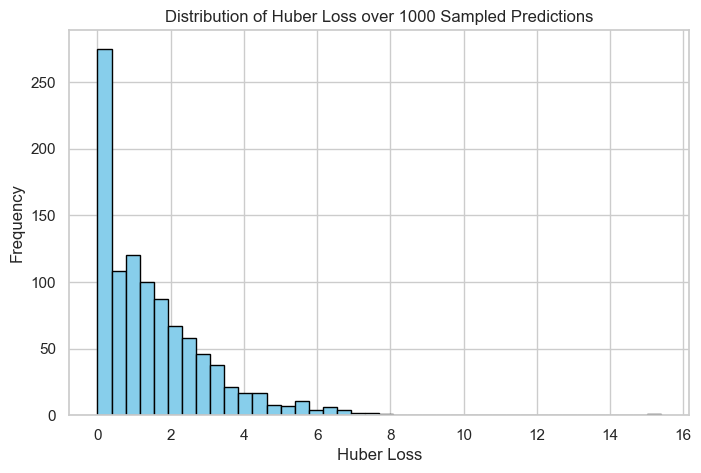

In [119]:
huber = HuberLoss(reduction='none')
losses = huber(preds, y_sample).cpu().numpy()

plt.figure(figsize=(8, 5))
plt.hist(losses, bins=40, color='skyblue', edgecolor='black')
plt.xlabel("Huber Loss")
plt.ylabel("Frequency")
plt.title("Distribution of Huber Loss over 1000 Sampled Predictions")
plt.grid(True)
plt.show()
